# Nonlinear Elasticity in a multipatch domain


In [1]:
%pylab inline
import scipy
import itertools

from pyiga import bspline, assemble, vform, geometry, vis, solvers

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

# assemble matrix
from scipy.sparse import coo_matrix, block_diag, bmat

# line search
from scipy.optimize import line_search

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
# 3 D #
p = 3  # spline degree 
n_el = (6, 3, 3)  # number of elements in x, y, z direction, isotropic material
# displacement space: degree p,   continuity p-1
kvs_u = tuple(bspline.make_knots(p, 0.0, 1.0, n, mult=1) for n in n_el) # or : mult=2
m_u = tuple(kv.numdofs for kv in kvs_u)


In [3]:
m_u

(9, 6, 6)

In [4]:
N = np.prod(tuple(kv.numdofs for kv in kvs_u))
print(N)
print(shape(m_u))

324
(3,)


In [5]:
def grid_eval(f, grid):
    """Evaluate function `f` over the tensor grid `grid`."""
    if hasattr(f, 'grid_eval'):
        return f.grid_eval(grid)
    else:
        mesh = np.meshgrid(*grid, sparse=True, indexing='ijk')
        mesh.reverse() # convert order ZYX into XYZ
        values = f(*mesh)
        return _ensure_grid_shape(values, grid)

In [6]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.collections import LineCollection
from mpl_toolkits import mplot3d

def plot_geo(geo, grid=10, gridx=None, gridy=None, gridz= None,
             res=30,
             linewidth=None, color='black',  **kwargs):
    """Plot a wireframe representation of a 2D geometry."""
    #fig = plt.figure()
    
    if geo.sdim == 1 and geo.dim == 2:
        print("plot_curve")
        return plot_curve(geo, res=res, linewidth=linewidth, color=color)
    
    #print("geo.sdim:", geo.sdim)
    #print("geo.dim:", geo.dim)
    
    if geo.dim == geo.sdim == 2:
        #assert geo.dim == geo.sdim == 2, 'Can only plot 2D geometries'
        if gridx is None: gridx = grid
        if gridy is None: gridy = grid
        supp = geo.support

        # if gridx/gridy is not an array, build an array with given number of ticks
        if np.isscalar(gridx):
            gridx = np.linspace(supp[0][0], supp[0][1], gridx)
        if np.isscalar(gridy):
            gridy = np.linspace(supp[1][0], supp[1][1], gridy)

        meshx = np.linspace(supp[0][0], supp[0][1], res)
        meshy = np.linspace(supp[1][0], supp[1][1], res)

        def plotline(pts, capstyle='butt'):
            plt.plot(pts[:, 0], pts[:, 1], color=color, linewidth=linewidth,
                     solid_joinstyle='round', solid_capstyle=capstyle)

        pts = grid_eval(geo, (gridx, meshy))
        plotline(pts[0, :, :], capstyle='round')
        for i in range(1, pts.shape[0] - 1):
            plotline(pts[i, :, :])
        plotline(pts[-1, :, :], capstyle='round')

        pts = grid_eval(geo, (meshx, gridy))
        plotline(pts[:, 0, :], capstyle='round')
        for j in range(1, pts.shape[1] - 1):
            plotline(pts[:, j, :])
        plotline(pts[:, -1, :], capstyle='round')

    
    if geo.sdim == geo.dim == 3:
        #print("3D geometry")
        # syntax for 3-D projection
        #ax = plt.axes(projection ='3d')
        #assert geo.dim == geo.sdim == 3, 'Can only plot 3D geometries'
        
        if gridx is None: gridx = grid
        if gridy is None: gridy = grid
        if gridz is None: gridz = grid
        supp = geo.support
        
        # if gridx/gridy is not an array, build an array with given number of ticks
        if np.isscalar(gridx):
            gridx = np.linspace(supp[0][0], supp[0][1], gridx)
            #print(gridx)
        if np.isscalar(gridy):
            gridy = np.linspace(supp[1][0], supp[1][1], gridy)
        if np.isscalar(gridz):
            gridz = np.linspace(supp[2][0], supp[2][1], gridz)

        meshx = np.linspace(supp[0][0], supp[0][1], res)
        #print(meshx)
        meshy = np.linspace(supp[1][0], supp[1][1], res)
        meshz = np.linspace(supp[2][0], supp[2][1], res)

        def plotline(pts, capstyle='butt'):
            ax.plot_surface(pts[..., 0], pts[..., 1], pts[..., 2], cmap=cm.coolwarm, linewidth=linewidth,  **kwargs)

        pts = grid_eval(geo, (gridx, meshy, meshz))# meshy
        plotline(pts[0, :, :], capstyle='round')# beginning
        for i in range(1, pts.shape[0] - 1): 
            plotline(pts[i, :, :]) # inbetween
        plotline(pts[-1, :, :], capstyle='round') # end

        pts = grid_eval(geo, (meshx, gridy, meshz))
        plotline(pts[:, 0, :], capstyle='round')
        for j in range(1, pts.shape[1] - 1):
            plotline(pts[:, j, :])
        plotline(pts[:, -1, :], capstyle='round')

        pts = grid_eval(geo, (meshx, meshy, gridz))
        plotline(pts[:, :, 0], capstyle='round')
        for k in range(1, pts.shape[2] - 1): 
            plotline(pts[:, :, k])
        plotline(pts[:, :, -1], capstyle='round')

        # plotting
        #ax.set_title('3D line plot')
        #plt.show()


In [7]:
geo = geometry.unit_square()

In [8]:
geo = geometry.unit_cube()


In [9]:
geo = geometry.twisted_box()

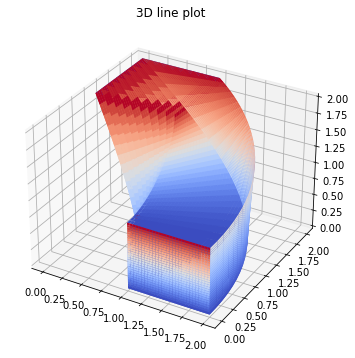

In [10]:
figsize(8,6)
fig = plt.figure()
ax = plt.axes(projection ='3d')

plot_geo(geo)
#axis('scaled');
ax.set_title('3D line plot')
plt.show()

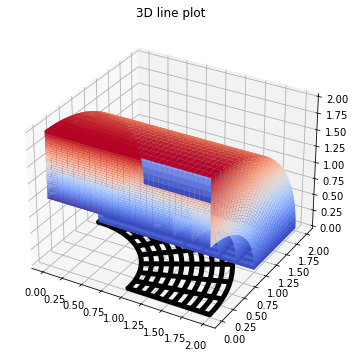

In [11]:
G = geometry.tensor_product(geometry.quarter_annulus(), geometry.line_segment(0,2))
G2 =  geometry.quarter_annulus()
#G = geometry.tensor_product(geometry.line_segment(0,1), geometry.quarter_annulus())
figsize(8,6)
fig = plt.figure()
ax = plt.axes(projection ='3d')
plot_geo(G) #vmin=0.0, vmax=2.5e-2 3D

plot_geo(G2, linewidth=5) #vmin=0.0, vmax=2.5e-2 2D
ax.set_title('3D line plot')
plt.show()

In [12]:
# define geometry
# realistic model of an artery: r_inner= 4mm, r_outer= 7mm (preprint)
# human carotid artery: r_i= 3.1 mm, r_o= 4mm (Holzapfel)
r_out = 0.4
r_in = 0.31

geos = [
 
    geometry.quarter_annulus(r1=r_in, r2=r_out),
    geometry.quarter_annulus(r1=r_in, r2=r_out).rotate_2d(3*pi/2),
    geometry.quarter_annulus(r1=r_in, r2=r_out).rotate_2d(pi),
    geometry.quarter_annulus(r1=r_in, r2=r_out).rotate_2d(pi/2)
]


# 3D
#geos_3d = [geometry.tensor_product(geometry.line_segment(0,1), g) for g in geos]
geos_3d = [geometry.tensor_product(g, geometry.line_segment(0,1)) for g in geos]

In [13]:
patches_u = [(kvs_u, g) for g in geos_3d] # 3D

# Here we auto-detect the interfaces between the patches.
MP_u = assemble.Multipatch(patches_u, automatch=True) #3D

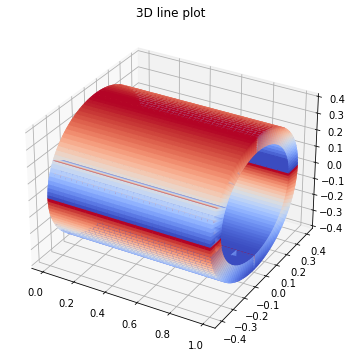

In [14]:
figsize(8,6)
fig = plt.figure()
ax = plt.axes(projection ='3d')

for g in geos_3d:
    plot_geo(g)#, vmin=0, vmax=7.5)

ax.set_title('3D line plot')
plt.show()

In [293]:
#split the solution into its components (displacement in x- and y- direction)
# visualization per patch , 2D only!
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from matplotlib.ticker import LinearLocator
from matplotlib import cm
### 3d surface

def get_defplot(u, patches_u, kvs_u, grid=10, gridx=None, gridy=None, gridz= None,
             res=20, linewidth=None, color='black',  **kwargs):
    """Split solution vector into displacement components."""
    u1 = u[:MP_u.numdofs] 
    u2 = u[MP_u.numdofs:2*MP_u.numdofs]
    u3 = u[2*MP_u.numdofs:3*MP_u.numdofs]
   
    # restrict solution to each individual patch - BSpline functions
    u1_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u1)
           for p in range(len(patches_u))]
    u2_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u2)
           for p in range(len(patches_u))]
    u3_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u3)
           for p in range(len(patches_u))]
    
    figsize(10,10)
    #fig, ax = plt.subplots()
    fig = plt.figure()
    ax = plt.axes(projection ='3d')
    
     # visualization per patch
    for (u1_func, u2_func, u3_func, (kvs, geo)) in zip(u1_funcs, u2_funcs, u3_funcs, patches_u): #u_funcs 

        if gridx is None: gridx = grid
        if gridy is None: gridy = grid
        if gridz is None: gridz = grid
        supp = geo.support
        
        # if gridx/gridy is not an array, build an array with given number of ticks
        if np.isscalar(gridx):
            gridx = np.linspace(supp[0][0], supp[0][1], gridx) # e.g. linespace(0, 1, 10)
        if np.isscalar(gridy):
            gridy = np.linspace(supp[1][0], supp[1][1], gridy)
        if np.isscalar(gridz):
            gridz = np.linspace(supp[2][0], supp[2][1], gridz)

        meshx = np.linspace(supp[0][0], supp[0][1], res) # e.g. linespace(0, 1, 50)
        meshy = np.linspace(supp[1][0], supp[1][1], res)
        meshz = np.linspace(supp[2][0], supp[2][1], res)
  
    # 3D surface plot  
    ## checkerboad pattern:
    # Create an empty array of strings with the same shape as the meshgrid, and
    # populate it with two colors in a checkerboard pattern.
        xlen = len(meshx)
        ylen = len(meshy)
        X, Y = np.meshgrid(meshx, meshy)
        colortuple = ('y', 'b')
        colors = np.empty(X.shape, dtype=str)
        for y in range(ylen):
            for x in range(xlen):
                 colors[y, x] = colortuple[(x + y) % len(colortuple)]
    
                
        def plotline(pts, capstyle='butt'):
            #surf = ax.plot_surface(pts[..., 0], pts[..., 1], pts[..., 2], cmap='viridis', vmin=c_min, vmax=c_max)
        
            #c_color = np.sqrt(pts[..., 1]**2 + pts[..., 2]**2)/r_out
            c_color = (pts[..., 1]**2 + pts[..., 2]**2)/r_in
            #c_color = c_l2
            ax.plot_surface(pts[..., 0], pts[..., 1], pts[..., 2],linewidth=0, antialiased=False, shade = False, alpha = 0.3, facecolors=cm.viridis(c_color), vmin=c_min, vmax=c_max)
            #ax.plot_wireframe(pts[..., 0], pts[..., 1], pts[..., 2], linewidth=1, color='grey') # grid
            #ax.plot_surface(pts[..., 0], pts[..., 1], pts[..., 2]) # one color
            #ax.plot_surface(pts[..., 0], pts[..., 1], pts[..., 2], facecolors=colors, linewidth=0) # checkerboard

        xgridyz = (gridx , meshy, meshz)
        ygridxz = (meshx, gridy, meshz)
        zgridxy = (meshx, meshy, gridz)
        
        # x-grid
        dis1 = u1_func.grid_eval(xgridyz) #x-value evaluated on 3-dim grid
        dis2 = u2_func.grid_eval(xgridyz) #y-value
        dis3 = u3_func.grid_eval(xgridyz) #z-value
        dis = np.stack((dis1,dis2, dis3), axis=-1) # displacement evaluated on 3-dim grid
        
        l2 = np.sqrt(np.power(dis[..., 1],2) + np.power(dis[..., 2],2))**2 # y^2 + z^2
        c_l2 = l2[0,:,:]
        #print('l2',l2[0,:,:])
        # normed colors:        
        c_faces = np.mean(dis, axis=(1, 2))  # size reduces by 1
        #print(c_faces)
        # color map and normalization
        c_min, c_max = np.min(c_faces), np.max(c_faces) 
        #c_min, c_max = 0.0, 1.5e-4
        norm = mpl.colors.Normalize(vmin=c_min, vmax=c_max)
        
    
        
        pts = grid_eval(geo, xgridyz) + dis  # + displacement x-coord
        plotline(pts[0, :, :], capstyle='round')# beginning
        for i in range(1, pts.shape[0] - 1): 
            plotline(pts[i, :, :])               # inbetween
        plotline(pts[-1, :, :], capstyle='round') # end
        
        
        # y-grid 
        dis1 = u1_func.grid_eval(ygridxz) #x-value evaluated on 3-dim grid
        dis2 = u2_func.grid_eval(ygridxz) #y-value
        dis3 = u3_func.grid_eval(ygridxz) #z-value
        dis = np.stack((dis1,dis2, dis3), axis=-1) # displacement evaluated on 3-dim grid

    
        pts = grid_eval(geo, ygridxz) + dis  # + displacement y-coord
        plotline(pts[:, 0, :], capstyle='round')
        for j in range(1, pts.shape[1] - 1):
            plotline(pts[:, j, :])
        plotline(pts[:, -1, :], capstyle='round')
        
        # z-grid
        dis1 = u1_func.grid_eval(zgridxy) #x-value evaluated on 3-dim grid
        dis2 = u2_func.grid_eval(zgridxy) #y-value
        dis3 = u3_func.grid_eval(zgridxy) #z-value
        dis = np.stack((dis1,dis2, dis3), axis=-1) # displacement evaluated on 3-dim grid     
        
        pts = grid_eval(geo, zgridxy) + dis # # + displacement z-coord
        #pts =  G[..., 2] + displ[..., 2]
        plotline(pts[:, :, 0], capstyle='round')
        for k in range(1, pts.shape[2] - 1): 
            plotline(pts[:, :, k])
        plotline(pts[:, :, -1], capstyle='round')
        
    
    
    cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='viridis'), ax=ax, pad=0.2)
    
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    
    plt.show()

In [294]:
class multipatch_block_handler:
    
    # Takes array of multi-patch objects
    def __init__( self, multi_patches ):
        self.multi_patches = multi_patches
        self.numpatches = multi_patches[0].numpatches
        for multi_patch in multi_patches:
            if multi_patch.numpatches != self.numpatches:
                print("Inconsistent numbers of patches")

    def patch_to_global(self, p):
        first = True
        for multi_patch in self.multi_patches:
            if first:
                X = multi_patch.patch_to_global(p)
                first = False
            else:
                X = scipy.sparse.block_diag((X,multi_patch.patch_to_global(p)))
        return X
    
    def compute_dirichlet_bcs(self, data):
        first = True
        p = 0
        offset = 0
        for multi_patch in self.multi_patches:
            data_p = []
            for item in data:
                if len(item)<4 or p in item[3]:
                    data_p.append( (item[0], item[1], lambda *x : item[2](*x)[p]) )
            if len(data_p)>0:
                bcs_p = multi_patch.compute_dirichlet_bcs(data_p)
                if first:
                    bcs = list(bcs_p)
                    first = False
                else:
                    #Indices need offset
                    bcs[0] = numpy.concatenate((bcs[0],bcs_p[0]+offset))
                    #Values are kept as-is
                    bcs[1] = numpy.concatenate((bcs[1],bcs_p[1]))
            offset += multi_patch.numdofs
            p += 1
        return tuple(bcs)
    
    def compute_local_offset_for_component(self, p, c):
        offset = 0
        for cc in range(c):
            dim = 1
            kvs, geo = self.multi_patches[cc].patches[p]
            for kv in kvs:
                dim *= kv.numdofs
            offset += dim
        return offset


In [295]:
# define boundary conditions

In [296]:
# source term f, 3D
def f(x, y, z): return (0.0, 0.0, 0.0)

In [297]:
#Neumann BC
def gN(x, y, z): 
#quarter annulus in y/z coord.system
    return (0, y/r_in*loading_value, z/r_in*loading_value) # inner pressure
# quarter annulus in x/x coord.system
   # return (x/r_out*loading_value, y/r_out*loading_value, 0)  #inner  pressure, normalized vector
# normal direction in z does not exist by now!

#incremental loading
#loading = [5e-5, 6e-5, 7e-5, 8e-5, 9e-5, 1e-4] #, 1.25e-4]
loading = [1e-4, 2e-4, 3e-4, 4e-4, 5e-4]

# set loading_value (used in 1st iteration, lin. problem)
loading_value = loading[-1]
#loading_value =  1e-3

neu_data = [(0,'bottom',gN), (1,'bottom',gN), (2,'bottom',gN), (3,'bottom',gN)] 
#neu_data = [] # no neumann bd cond.

In [298]:
# Multipatch objects for all variables (x, y, z)
MP_block = multipatch_block_handler( [MP_u, MP_u, MP_u] ) 

In [299]:
# define Dirichlet boundary function 
def g_zero(x, y, z): return (0.0, 0.0, 0.0) # fixed in y/z, x runs, evtl. set x=x

# set up Dirichlet boundary conditions
bc = MP_block.compute_dirichlet_bcs([
    (1, 'top', g_zero ) # outer bd, 1
])

In [300]:
# Compute solution of nonlinear elasticity problem

In [301]:
#split the solution into its components (displacement in x- and y- direction) and convert to BSpline function
def get_components(u, kvs_u):
    """Split solution vector into displacement components."""
    #print("shape_u", shape(u))
    N = np.prod(tuple(kv.numdofs for kv in kvs_u))
    u1 = u[:N].reshape(m_u)          
    u2 = u[N:2*N].reshape(m_u)    
    u3 = u[2*N:3*N].reshape(m_u)    
    U = np.stack((u1,u2,u3), axis=-1)
    return bspline.BSplineFunc(kvs_u, U)


In [302]:
# rubber, Lamé-coeff.
Mu = 0.003 # [GPa]
Lam = 0.00028416 #  [GPa] (under ass. ny=0.48, almost incompressible)
# incompressible: Lam = 0


# nonlinear variational form
def apply_nl(u_p, kvs_ux, geo_ux, X):
    dis = get_components(X.T @ u_p, kvs_ux)
    
    z_lam = Lam* assemble.assemble('div(dis)*div(v) * dx+ 1/2 *tr( grad(dis).T *grad(dis)) *div(v)*dx + inner(div(dis)*grad(dis), grad(v))*dx + inner(1/2 * tr(grad(dis).T *grad(dis))*grad(dis), grad(v)) *dx'
                             , kvs_ux, bfuns=[('v',3)], geo=geo_ux, dis=dis)
    z_mu = Mu* assemble.assemble('inner(grad(dis).T +grad(dis) + grad(dis).T *grad(dis), grad(v))*dx + inner(grad(dis)*(grad(dis).T +grad(dis) + grad(dis).T*grad(dis)), grad(v)) *dx'
                                    , kvs_ux, bfuns=[('v',3)], geo=geo_ux, dis=dis)
    return (z_lam + z_mu).ravel()  # vector z

# linearized variational form
def linearized(u_p, kvs_ux, geo_ux, X):
    dis = get_components(X.T @ u_p, kvs_ux)
    
    A_lin_lam = Lam* assemble.assemble('(inner( (div(dis) + 1/2 *tr( grad(dis).T *grad(dis) )) * grad(u), grad(v)) + div(u)*div(v) + tr( grad(dis).T *grad(u) ) * div(v) + inner( (div(u) + tr(grad(dis).T *grad(u)) ) * grad(dis), grad(v)) ) * dx'
                              , kvs_ux, bfuns=[('u',3), ('v',3)], geo=geo_ux, dis=dis) #matrix A_lam
    
    A_lin_mu = 2*Mu * assemble.assemble('(inner(1/2 * grad(u)*(grad(dis)+ grad(dis).T + grad(dis).T *grad(dis)) + (1/2) * (grad(u)+grad(u).T + grad(dis).T *grad(u) + grad(u).T *grad(dis)) + 1/2 * grad(dis)*(grad(u)+grad(u).T +grad(dis).T * grad(u)+ grad(u).T * grad(dis)), grad(v))) * dx'
                              , kvs_ux, bfuns=[('u',3), ('v',3)], geo=geo_ux, dis=dis) #matrix A_mu
    
    return A_lin_lam + A_lin_mu # matrix A



In [303]:
# assemble matrix A and rhs b for nonlinear elasticity problem
def ass_nonlinsystem(u):
    first = True
    for p in range(MP_block.numpatches):
        X = MP_block.patch_to_global(p)

        # All the geometries are supposed to be equal; also kvs_ux and kvs_uy are equal
        kvs_ux, geo_ux = MP_block.multi_patches[0].patches[p]
        #kvs_uy, geo_uy = MP_block.multi_patches[1].patches[p]
        #kvs_uz, geo_uz = MP_block.multi_patches[2].patches[p] # same as x

        # The whole patch-local stiffness matrix
        A_p = linearized(u, kvs_ux, geo_ux, X) # take linearized variatonal form

        # The patch-local right-hand side
        b_p = assemble.inner_products(kvs_ux, f, f_physical=True, geo=geo_ux).ravel() - apply_nl(u, kvs_ux, geo_ux, X) # for arbitrary rhs
        
        
        ##implemented normal vector
        #nv = assemble.assemble('inner(v, n) * ds', kvs_ux, bfuns=[('v', 3)], geo=geo_ux, boundary='bottom', layout='packed')
        #print(nv.sum(axis=(0,1,2)))

        # The patch-local Neumann boundary data
        for item in neu_data:
            if item[0]==p:
                N_e = assemble.assemble('inner(n,v)*ds', kvs_ux, bfuns=[('v',3)], geo=geo_ux, boundary=item[1]).ravel()
                N_e *= -loading_value
                #N_e  = assemble.assemble('inner(g,v)*ds', kvs_ux, geo=geo_ux, g=item[2], bfuns=[('v', 3)], symmetric=True, boundary=item[1] ).ravel()
                N_e = N_e.reshape(3, -1) # 3dim, -1 remaining factor to get to the total number of elements
                #print("N_e", shape(N_e))
                bdofs = assemble.boundary_dofs(kvs_ux, item[1], ravel=True)
                len_bdofs = len(bdofs)
                for c in range(3):
                    offset = MP_block.compute_local_offset_for_component(p,c)
                    for i in range(len_bdofs):
                        b_p[bdofs[i]+offset] += N_e[c,i]  #N_e[c,i,0, 0] #N_e[c,i,0]
      
        if first:
            A = X @ A_p @ X.T
            b = X @ b_p 
            first = False
        else:
            A += X @ A_p @ X.T
            b += X @ b_p 
    
    return A, b

In [304]:
# elasticity problem
#linear problem = linearized problem (for development point x_0=(0...0) )
def grad_J(x): #nonlin function (rhs) 
    u_p = x
    first = True
    for p in range(MP_block.numpatches): # go through each patch
        X = MP_block.patch_to_global(p)
        kvs_ux, geo_ux = MP_block.multi_patches[0].patches[p]

        b_p= apply_nl(u_p, kvs_ux, geo_ux, X) #non-linear form a(u,v)

        b0_p = assemble.inner_products(kvs_ux, f, f_physical=True, geo=geo_ux).ravel() # rhs (0,0,...,0) for nbc

        for item in neu_data:
            if item[0]==p:
                N_e = assemble.assemble('inner(n,v)*ds', kvs_ux, bfuns=[('v',3)], geo=geo_ux, boundary=item[1]).ravel()
                N_e *= -loading_value
                #N_e  = assemble.assemble('inner(g,v)*ds', kvs_ux, bfuns=[('v',3)], geo=geo_ux, g=item[2], boundary=item[1]).ravel()
                N_e = N_e.reshape(3, -1)
                bdofs = assemble.boundary_dofs(kvs_ux, item[1], ravel=True)
                for c in range(3):
                    offset = MP_block.compute_local_offset_for_component(p,c)
                    for i in range(len(bdofs)):
                        b_p[bdofs[i]+offset] += N_e[c,i]  #N_e[c,i,0, 0] #N_e[c,i,0]
         
        if first:
            grad_b = X @ (b_p- b0_p)#"Au-b"
            first = False
        else:
            grad_b += X @ (b_p- b0_p) 
            
    return grad_b


# define constant spline functions for integration
kvs_j = tuple(bspline.make_knots(0, 0.0, 1.0, n, mult=1) for n in n_el) # constant basis vector for integration

def J(x): #energy functional, scalar valued
    u_p = x
    j_N = 0
    j = 0
    for p in range(MP_block.numpatches): # go through each patch
        X = MP_block.patch_to_global(p)
        kvs_ux, geo_ux = MP_block.multi_patches[0].patches[p]

        dis = get_components(X.T @ u_p, kvs_ux)
        j_lam = Lam/8 * assemble.assemble('tr( grad(dis).T *grad(dis) +grad(dis).T +grad(dis))**2 *v*dx'
                             , kvs_j, bfuns=[('v',1)], geo=geo_ux, dis=dis).ravel()
        j_mu = Mu/4 * assemble.assemble('tr((grad(dis).T *grad(dis) +grad(dis).T +grad(dis))*(grad(dis).T *grad(dis) +grad(dis).T +grad(dis))) *v*dx'
                                    , kvs_j, bfuns=[('v',1)], geo=geo_ux, dis=dis).ravel()
        j_p = sum(j_lam + j_mu)
        
        for item in neu_data:
            if item[0]==p:
                N_e = -assemble.assemble('inner(n, dis) *v * ds', kvs_j, bfuns=[('v',1)], geo=geo_ux, boundary=item[1], dis=dis)
                N_e *= loading_value
                #N_e  = assemble.assemble('inner(g,dis) *v *ds', kvs_j, bfuns=[('v',1)], geo=geo_ux, g=item[2], boundary=item[1], dis=dis) 
                j_N += N_e.sum()

        j += (j_p - j_N)
        
    return j


In [305]:
def Wolfe_LineSearch(f, f_grad, xk, pk):
    # Wolfe-Powell_Line search
    print('Start line search')
    
    mu1 = 0.01
    sigma = 0.9
    tau = 0.1
    tau1 = 0.3
    tau2 = 0.9
    gsi1 = 1
    gsi2 = 10
    
    def phi(alpha):
        return f(xk + alpha * pk)

    def derphi(alpha):
        return np.dot(f_grad(xk + alpha * pk), pk)
    
    alpha_L = 0
    alpha_R = None
    phi_L = phi(0)
    derphi_L = derphi(0)
    alphainf= True
    alpha =1 
    phi_min = -1.e2
    eps0 = 1.e-6
    max_iter = 5
    n_iter = 0
    
    while n_iter < max_iter:
        print("  {}. alpha between {} and {}".format(n_iter,alpha_L,alpha_R))
        n_iter +=1
        if alpha > 1: # alpha too big # alpha in(0,1)!
            print('alpha >1')
            alpha_R = alpha
            alpha= alpha_L + tau1*(alpha_R - alpha_L)
        else:
            #print('a=', alpha)
            phi_hat= phi(alpha)
            if phi_hat < phi_min: # function unbounded to the bottom
                return alpha 

            if phi_hat > phi(0) + mu1*alpha*derphi(0): #alpha too big # 
                if derphi(0) >= 0:
                    print('  no descent direction')
                
                alphainf= False
                alpha_R = alpha
                delta = alpha_R - alpha_L
               # print('  delta=', delta)
                ## interpolation
                c = (phi_hat - phi_L - derphi_L*delta)/delta**2
                alpha_tilde = alpha_L - derphi_L/(2*c)
                alpha = min(max(alpha_L+ tau*delta, alpha_tilde), alpha_R - tau*delta)
                print('alpha_int=', alpha)
            
            else: # alpha too small & not too big
                derphi_hat = derphi(alpha)
                if derphi_hat < sigma*derphi(0): # alpha too small
                    print('  alpha too small')
                    if alphainf: # true, alpha_R =inf
                        print('  alpha_R = inf')
                        if derphi_L/derphi_hat > (1+ gsi2)/gsi2:
                            alpha_tilde = alpha + (alpha - alpha_L)*max(derphi_hat/(derphi_L -derphi_hat), gsi1)
                        else:
                            alpha_tilde = alpha + gsi2*(alpha - alpha_L)
                    else: # alpha_R < inf
                        print('  alpha_R < inf')
                        if derphi_L/derphi_hat > 1 + (alpha-alpha_L)/(tau2*(alpha_R -alpha)):
                            alpha_tilde = alpha + max((alpha-alpha_L)*derphi_hat/(derphi_L - derphi_hat), tau1*(alpha_R- alpha))
                        else:
                            alpha_tilde = alpha + tau2*(alpha_R - alpha)
                    ## update
                    alpha_L = alpha
                    phi_L = phi_hat
                    derphi_L = derphi_hat
                    alpha = alpha_tilde
                
                else:
                    return alpha

      

In [306]:
def make_solver_orig(B, symmetric=False, spd=False):
    """Return a :class:`LinearOperator` that acts as a linear solver for the
    (dense or sparse) square matrix `B`.

    If `B` is symmetric, passing ``symmetric=True`` may try to take advantage of this.
    If `B` is symmetric and positive definite, pass ``spd=True``.
    """
    if spd:
        symmetric = True
# Gauß'sche Eliminationsverfahren - LU Zerlegung (auch LR für left-right)
    if scipy.sparse.issparse(B):
        print('use SuperLU')
            # use SuperLU (unless scipy uses UMFPACK?) -- really slow!
        spLU = scipy.sparse.linalg.splu(B.tocsc(), permc_spec='NATURAL')
        M= scipy.sparse.linalg.LinearOperator(B.shape, dtype=B.dtype, matvec=spLU.solve, matmat=spLU.solve)
        return M
# Cholesky Zerlegung: Matrix muss symmetrisch und positiv definit sein!                  
    else:
        if symmetric:
            print('use Cholesky')
            chol = scipy.linalg.cho_factor(B, check_finite=False)
            solve = lambda x: scipy.linalg.cho_solve(chol, x, check_finite=False)
            return scipy.sparse.linalg.LinearOperator(B.shape, dtype=B.dtype,
                    matvec=solve, matmat=solve)
        else:
            print('Matrix is not symmetric')
            LU = scipy.linalg.lu_factor(B, check_finite=False)
            solve = lambda x: scipy.linalg.lu_solve(LU, x, check_finite=False)
            return scipy.sparse.linalg.LinearOperator(B.shape, dtype=B.dtype,
                    matvec=solve, matmat=solve)
   

In [307]:
def make_solver(matrix):
    B= matrix.todense()
    """Return a :class:`LinearOperator` that acts as a linear solver for the
    (dense or sparse) square matrix `B`.

    If `B` is symmetric, passing ``symmetric=True`` may try to take advantage of this.
    If `B` is symmetric and positive definite, pass ``spd=True``.
    """
    
    chol = scipy.linalg.cho_factor(B, check_finite=False) # for s. p.d matrix
    solve = lambda x: scipy.linalg.cho_solve(chol, x, check_finite=False)
    return scipy.sparse.linalg.LinearOperator(B.shape, dtype=B.dtype, matvec=solve, matmat=solve)
       

In [308]:
def solve(matrix, vector):
    try:
        return make_solver(matrix).dot(vector)
    # cholesky --> takes spd matrix
    except LinAlgError:
        print('use Gradient direction') # matrix not positive definite
        return vector
        #return 10000*vector
        

In [309]:
# solve linearized system 
### first iteration ###
XP = MP_block.patch_to_global(0) #p=0
dd = shape(XP)[0]

#initial value
u= np.zeros(dd)
solutions= []

# set Neumann boundary force (via incremental loading) 
#neu_data = [(0,'left',gN), (1,'left',gN), (2,'left',gN), (3,'left',gN)] 
    
### first iteration ###
A, b= ass_nonlinsystem(u)
LS = assemble.RestrictedLinearSystem(A, b, bc) # solve linearized system
r0= np.linalg.norm(LS.b) # rhs of undeformed system
print('r0=', r0)

u_d = make_solver_orig(LS.A).dot(LS.b) 
u_d = LS.complete(u_d)
u += u_d


A, b= ass_nonlinsystem(u)
LS = assemble.RestrictedLinearSystem(A, b, bc) # solve linearized system


r= np.linalg.norm(LS.b) # compute residuum
print('residual = ', r)

###-----------------###--------------------###
solutions = [LS.restrict(u)]
# norm of delta u in first step
normed_du0= np.linalg.norm(u_d)/np.sqrt(len(u_d))
###----------------###---------------------###

r0= 7.908345817934471e-05
use SuperLU
residual =  5.8699634059676916e-05


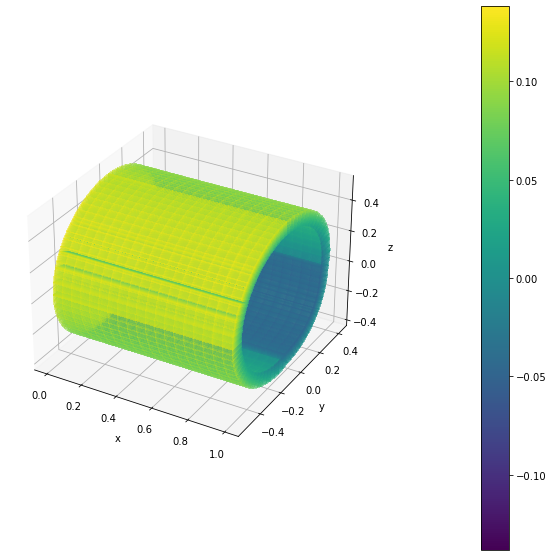

In [310]:
# print deformation plot
get_defplot(u, patches_u, kvs_u)

In [311]:
solutions

[array([0.00180616, 0.00076085, 0.00034072, ..., 0.03921386, 0.039658  ,
        0.03977299])]

In [312]:
print(shape(solutions))

(1, 3294)


 
 
 1. loading: 0.0001 

1
use SuperLU
5.8530631693698384e-05
Start line search
  0. alpha between 0 and None
alpha= 1
residual =  4.416980845984873e-05
2
use SuperLU
3.1887527947630127e-06
Start line search
  0. alpha between 0 and None
alpha= 1
residual =  6.378745639973999e-06
3
use SuperLU
1.3270510741922275e-07
Start line search
  0. alpha between 0 and None
  no descent direction
alpha_int= 0.1
  1. alpha between 0 and 1
  no descent direction
alpha_int= 0.010000000000000002
  2. alpha between 0 and 0.1
  no descent direction
alpha_int= 0.0010000000000000002
  3. alpha between 0 and 0.010000000000000002
  no descent direction
alpha_int= 0.00010000000000000003
  4. alpha between 0 and 0.0010000000000000002
  no descent direction
alpha_int= 1.0000000000000004e-05
alpha= None
residual =  3.5880347640512024e-06
4
use SuperLU
3.105113561390009e-08
Start line search
  0. alpha between 0 and None
alpha_int= 0.1
  1. alpha between 0 and 1
alpha_int= 0.010000000000000002
  2. alpha betwe

  no descent direction
alpha_int= 1.0000000000000004e-05
alpha= None
residual =  6.9469209501435606e-06
3
use SuperLU
-2.794812586422422e-07
Matrix is not positive definit! 

Start line search
  0. alpha between 0 and None
  no descent direction
alpha_int= 0.1
  1. alpha between 0 and 1
  no descent direction
alpha_int= 0.010000000000000002
  2. alpha between 0 and 0.1
  no descent direction
alpha_int= 0.0010000000000000002
  3. alpha between 0 and 0.010000000000000002
  no descent direction
alpha_int= 0.00010000000000000003
  4. alpha between 0 and 0.0010000000000000002
  no descent direction
alpha_int= 1.0000000000000004e-05
alpha= None
residual =  4.324017423609726e-06
4
use SuperLU
-1.1002248691780002e-07
Matrix is not positive definit! 

Start line search
  0. alpha between 0 and None
alpha_int= 0.1
  1. alpha between 0 and 1
alpha_int= 0.010000000000000002
  2. alpha between 0 and 0.1
alpha_int= 0.0010000000000000002
  3. alpha between 0 and 0.010000000000000002
alpha_int= 0.0001

residual =  1.905606337785609e-09


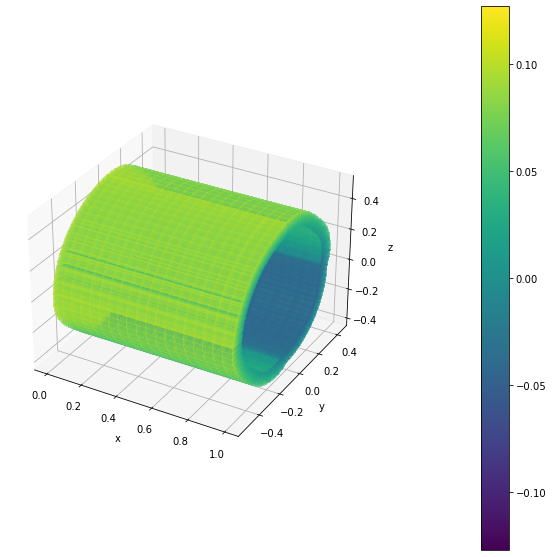

In [313]:
# solve linearized variational problem

epsilon= 1e-3 #1e-6

#solutions= []

stepsizes =[] 
ud_array = []

# incremental loading # ----------------------------------
for i in range(len(loading)):
    print(" \n \n {}. loading: {} \n".format(i+1,loading[i]))
    
    # set Neumann data via incremental loading
    loading_value = loading[i]
    #g_N = gN 
    # neu_data = [(0,'right',g_N), (1,'right',g_N), (2,'right',g_N), (3,'right',g_N)] # outer radius
    neu_data = [(0,'bottom',gN), (1,'bottom',gN), (2,'bottom',gN), (3,'bottom',gN)] # inner radius
    
    count= 0
    while True:
        count+=1
        print(count)

        # Assemble matrices and rhs in every iteration step
        A, b= ass_nonlinsystem(u)
        LS = assemble.RestrictedLinearSystem(A, b, bc) # solve linearized system

        # # solve system # #
        #u_d= solvers.make_solver(LS.A).dot(LS.b)
        u_d = make_solver_orig(LS.A).dot(LS.b) 

        # check if matrix is positive definite in a particular direction u_d
        if LS.b.dot(u_d) <= 0:
            print(LS.b.dot(u_d)) #transpose(LS.b)*M*LS.b
            print('Matrix is not positive definit! \n')
        else:
            print(LS.b.dot(u_d))

        # complete system dependent solution
        u_d = LS.complete(u_d)

        # # do Wolfe-Powell line search # # 
        alpha= Wolfe_LineSearch(J, grad_J, u, u_d) 
        #alpha= line_search(J, grad_J, u, u_d) # use integrated line search (scipy)
        print('alpha=', alpha)
        if alpha == None:
            u += 0.5 * u_d # alpha=0.5 (ignore line search)
        else:
            u += alpha * u_d

            
        # compute new non-linear residuum
        A, b = ass_nonlinsystem(u)
        LS = assemble.RestrictedLinearSystem(A, b, bc) # solve linearized system
        r = np.linalg.norm(LS.b) # compute residuum
        print('residual = ', r)
        
        #----------------------------------------------------#
        ud_array.append(u_d)
        normed_du = np.linalg.norm(u_d)/np.sqrt(len(u_d))
        stepsize_du = abs(normed_du0-normed_du)
        stepsizes.append(stepsize_du)
        normed_du0 = normed_du
        #---------------------------------------------------#

        if r < epsilon* r0: # break condition
            break
        elif count == 30:
            break
            
    solutions.append([LS.restrict(u)])
        
# print deformation plot
get_defplot(u, patches_u, kvs_u)

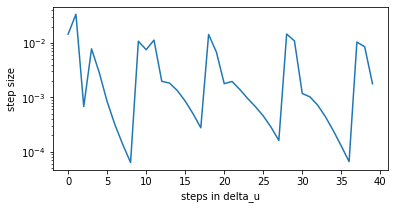

In [314]:
# plot history of step sizes
figsize(6,3)
yscale('log')
plot(stepsizes);
xlabel('steps in delta_u'); ylabel('step size');

In [315]:
shape(solutions)

(6,)

In [316]:
solutions

[array([0.00180616, 0.00076085, 0.00034072, ..., 0.03921386, 0.039658  ,
        0.03977299]),
 [array([3.57583894e-04, 1.44064775e-04, 6.73278803e-05, ...,
         4.62778778e-03, 4.70499559e-03, 4.73010649e-03])],
 [array([0.00057898, 0.00030458, 0.00011414, ..., 0.02657205, 0.0267776 ,
         0.0268512 ])],
 [array([0.000954  , 0.00040511, 0.00019508, ..., 0.02733686, 0.02755878,
         0.02763255])],
 [array([0.00121548, 0.00050398, 0.00022473, ..., 0.03399465, 0.03445552,
         0.0346096 ])],
 [array([0.00146211, 0.00057167, 0.00027574, ..., 0.03663249, 0.03703954,
         0.03720775])]]

In [317]:
#split the solution into its components (displacement in x- and y- direction)
# visualization per patch , 2D only!
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from matplotlib.ticker import LinearLocator
from matplotlib import cm
### 3d surface

def animate_field_3d(u, patches_u, kvs_u, grid=10, vrange=None,
             res=20, interval=50, cmap=None, progress=False):
    """Split solution vector into displacement components."""
        
    u1 = u[:MP_u.numdofs] 
    u2 = u[MP_u.numdofs:2*MP_u.numdofs]
    u3 = u[2*MP_u.numdofs:3*MP_u.numdofs]
   
    # restrict solution to each individual patch - BSpline functions
    u1_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u1)
           for p in range(len(patches_u))]
    u2_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u2)
           for p in range(len(patches_u))]
    u3_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u3)
           for p in range(len(patches_u))]
    
    figsize(10,10)
    fig = plt.figure()
    ax = plt.axes(projection ='3d')
    
     # visualization per patch
    for (u1_func, u2_func, u3_func, (kvs, geo)) in zip(u1_funcs, u2_funcs, u3_funcs, patches_u): #u_funcs 
        supp = geo.support
        gridx = np.linspace(supp[0][0], supp[0][1], res) # e.g. linespace(0, 1, 50)
        gridy = np.linspace(supp[1][0], supp[1][1], res)
        gridz = np.linspace(supp[2][0], supp[2][1], res)
        grd = (gridx , gridy, gridz)
                
        def plotline(pts, capstyle='butt'):
            surf = ax.plot_surface(pts[..., 0], pts[..., 1], pts[..., 2], cmap='viridis', vmin=c_min, vmax=c_max)
        
        dis1 = u1_func.grid_eval(grd) #x-value evaluated on 3-dim grid
        dis2 = u2_func.grid_eval(grd) #y-value
        dis3 = u3_func.grid_eval(grd) #z-value
        dis = np.stack((dis1,dis2, dis3), axis=-1) # displacement evaluated on 3-dim grid
        
        if vrange is None:
            # determine range of values from first field
            C = vis.utils.grid_eval(dis[0], grd)
            vrange = (C.min(), C.max())
        
        # normed colors:        
        c_faces = np.mean(dis, axis=(0, 1))  # size reduces by 1
        # color map and normalization
        c_min, c_max = np.min(c_faces), np.max(c_faces) 
        
        pts = grid_eval(geo, grd) + dis  # + displacement x-coord
        
        plotline(pts[0, :, :], capstyle='round')# beginning
        for i in range(1, pts.shape[0] - 1): 
            plotline(pts[i, :, :])               # inbetween
        plotline(pts[-1, :, :], capstyle='round') # end
        
    

    norm = mpl.colors.Normalize(vmin=c_min, vmax=c_max)
    cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, pad=0.2)
    
    tqdm = vis.utils.progress_bar(progress)
    pbar = tqdm(total=len(dis))

    def anim_func(i):
        C = grid_eval(dis[i], grd)
        surf.set_array(C.ravel())
        pbar.update()
        if i == len(fields) - 1:
            pbar.close()

    return animation.FuncAnimation(fig, anim_func, frames=len(dis), interval=interval)


In [318]:
def dis_norm(u):
    """Return a function for evaluating the norm of the displacement"""
    """Split solution vector into displacement components."""
    u1 = u[:MP_u.numdofs] 
    u2 = u[MP_u.numdofs:2*MP_u.numdofs]
    u3 = u[2*MP_u.numdofs:3*MP_u.numdofs]
   
    # restrict solution to each individual patch - BSpline functions
    u1_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u1)
           for p in range(len(patches_u))]
    u2_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u2)
           for p in range(len(patches_u))]
    u3_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u3)
           for p in range(len(patches_u))]
    def f(X, Y, Z):
        for (u1_func, u2_func, u3_func, (kvs, geo)) in zip(u1_funcs, u2_funcs, u3_funcs, patches_u): #u_funcs 
            dis1 = u1_func.grid_eval((Z,Y,X)) #x-value
            dis2 = u2_func.grid_eval((Z,Y,X)) #y-value
            dis3 = u3_func.grid_eval((Z,Y,X)) #z-value
            dis = np.stack((dis1,dis2, dis3), axis=-1)
            return norm(dis) # axis=-1 or 2
    return f

In [319]:
dis_norm(u)

<function __main__.dis_norm.<locals>.f(X, Y, Z)>

In [320]:
T_anim = linspace(0, 3, 200)   # animation timesteps
# interpolate adaptive solution at the animation frame times
fields = [dis_norm(u) for tt in T_anim]


In [321]:
#fields

  0%|          | 0/50 [00:00<?, ?it/s]

RuntimeError: Requested MovieWriter (ffmpeg) not available

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x0000025F60BE2940> (for post_execute):


ValueError: Valid values for `indexing` are 'xy' and 'ij'.

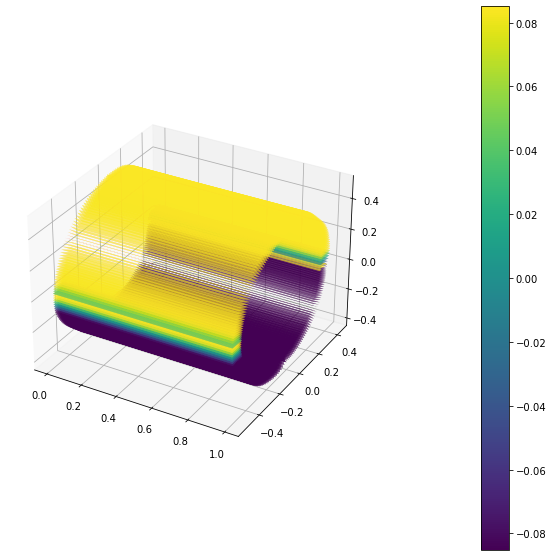

In [322]:
from IPython.display import HTML

figsize(14, 4)
HTML(animate_field_3d(u, patches_u, kvs_u, res=(50), vrange=(0,3), interval=35, progress=True).to_html5_video())

In [ ]:
M_u_full = np.eye(dd)


In [ ]:
# M_p = assemble.mass(kvs_ux, geo_ux)

In [ ]:
#M_u_full = scipy.sparse.bmat(
    #[[M_u_full , None, None  ],
    # [None, M_u_full , None  ],
    # [None, None, M_u_full ]], format='csr')


In [ ]:
def lin(u):
    first = True
    for p in range(MP_block.numpatches):
        X = MP_block.patch_to_global(p)

        # All the geometries are supposed to be equal; also kvs_ux and kvs_uy are equal
        kvs_ux, geo_ux = MP_block.multi_patches[0].patches[p]
        
        # The whole patch-local stiffness matrix
        A_p = linearized(u, kvs_ux, geo_ux, X) # take linearized variatonal form
      
        if first:
            A = X @ A_p @ X.T
            first = False
        else:
            A += X @ A_p @ X.T
    
    return A

In [ ]:
def nonlin(u):
    first = True
    for p in range(MP_block.numpatches):
        X = MP_block.patch_to_global(p)

        # All the geometries are supposed to be equal; also kvs_ux and kvs_uy are equal
        kvs_ux, geo_ux = MP_block.multi_patches[0].patches[p]
        
        # The patch-local right-hand side
        b_p = - apply_nl(u, kvs_ux, geo_ux, X) # for arbitrary rhs
        
        for item in neu_data:
            if item[0]==p:
                N_e = assemble.assemble('inner(n,v)*ds', kvs_ux, bfuns=[('v',3)], geo=geo_ux, boundary=item[1]).ravel()
                N_e *= -loading_value
                N_e = N_e.reshape(3, -1) # 3dim, -1 remaining factor to get to the total number of elements
                #print("N_e", shape(N_e))
                bdofs = assemble.boundary_dofs(kvs_ux, item[1], ravel=True)
                len_bdofs = len(bdofs)
                for c in range(3):
                    offset = MP_block.compute_local_offset_for_component(p,c)
                    for i in range(len_bdofs):
                        b_p[bdofs[i]+offset] += N_e[c,i] 
      
        if first:
            b = X @ b_p 
            first = False
        else:
            b += X @ b_p 
    
    return b

In [ ]:
# set up DAE for non-lin elasticity problem
def ns_F(x): #function
    u_p = LS.complete(x)
    return -LS.restrict(nonlin(u_p)) ## nonlin

def ns_J(x): # Jabobi
    u_p = LS.complete(x)
    return -LS.restrict_matrix(lin(u_p)) # linearized

ns_M = LS.restrict_matrix(M_u_full) # Navier-Stokes mass matrix

# M (matrix): the mass matrix
# F (function): the right-hand side
# J (function): function computing the Jacobian of `F`
# x (vector): the initial value

In [ ]:

# time step
tau = 2e-2

In [ ]:
ns_M

In [ ]:
t_end = 3.0

time_steps = solvers.rowdaind2(ns_M, ns_F, ns_J, solutions[-1], tau, t_end, tol=1e-2, progress=True)
solutions.extend(time_steps[1][1:])

In [ ]:
# plot history of step sizes
figsize(6,3)
times = array(time_steps[0])
stepsizes = times[1:] - times[:-1]
plot(times[:-1], stepsizes);
xlabel('time'); ylabel('step size');

In [ ]:
T_anim = linspace(0, 3, 200)   # animation timesteps
# interpolate adaptive solution at the animation frame times
sol_interp = scipy.interpolate.interp1d(time_steps[0],
                [LS.complete(uu) for uu in time_steps[1]], axis=0)
fields = [vel_norm(sol_interp(tt)) for tt in T_anim]

In [ ]:
from IPython.display import HTML

figsize(14, 4)
#fields = [vel_norm(LS.complete(uu)) for uu in solutions]
for g in geos:
    HTML(vis.animate_field(fields, g, res=(50, 150), vrange=(0,3), interval=35, progress=True).to_html5_video())